<a href="https://colab.research.google.com/github/goose1775/pln_python/blob/main/PLN_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

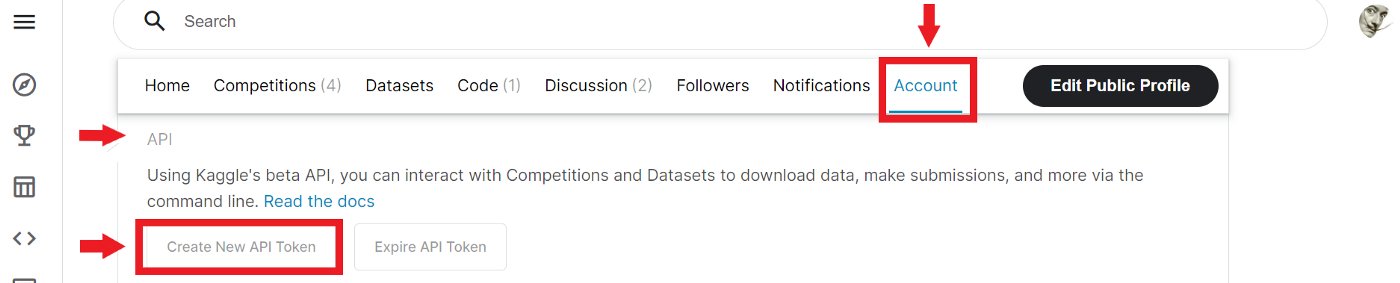

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json

In [1]:
#!pip install -q kaggle
#!rm -rf kaggle.json
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saulomarinato","key":"ddf45043b273520065b6ff3552074463"}'}

Crie a pasta .kaggle

In [2]:
!chmod 600 .kaggle/kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

chmod: cannot access '.kaggle/kaggle.json': No such file or directory


Baixe o dataset

In [3]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

 99% 186M/187M [00:02<00:00, 57.6MB/s]
100% 187M/187M [00:02<00:00, 77.7MB/s]


# Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [1]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

Download do modelo em portugês

In [2]:
#!python -m spacy download pt_core_news_lg

In [3]:
# Escreva seu código aqui
#!pip install --upgrade spacy
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

In [4]:
# Carregada modelo
nlp = spacy.load("pt_core_news_lg")

## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Carregar os módulos usados ao longo desse notebook

In [6]:
#!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem.rslp import RSLPStemmer
from spacy.lang.pt import Portuguese
import gensim
import gensim.corpora as corpora
from gensim.models import Doc2Vec, CoherenceModel
from gensim.models.doc2vec import TaggedDocument
import pickle

from wordcloud import WordCloud

import re
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from typing import List, Set, Any
from pprint import pprint

SEED = 123

# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [ ]:
#df['category'].value_counts()

In [7]:
# Convert the 'date' column to datetime if not already done
df['date'] = pd.to_datetime(df['date'])

# Filter rows for the year 2016 and category 'mercado'
news_2016 = df[(df['date'].dt.year == 2016) & (df['category'] == 'mercado')]

In [7]:
#Filter rows for category 'poder', no other filter
#news_2016 = df[(df['category'] == 'poder')]

In [8]:
#news_2016 = news_2016.sample(n=5000, random_state=42)
print('Tamanho da Amostra:', news_2016.shape[0])

Tamanho da Amostra: 7943


## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem).
Para tal, complete o conteúdo da função `tokenize`.

In [9]:
# Define the tokenize function
def tokenize(text: str) -> List[str]:
    """
    Function for tokenizing using `nltk.tokenize.word_tokenize` and stemming with `nltk.stem.RSLPStemmer`

    Returns:
        - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
        IMPORTANT: Only tokens with alphabetic characters will be returned.
    """
    # Initialize the stemmer
    stemmer = RSLPStemmer()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Stem each token and filter out non-alphabetic characters
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]

    return stemmed_tokens

# Apply the tokenize function to the 'text' column of news_2016 and add a new column named 'nltk_tokens'
news_2016['nltk_tokens'] = news_2016['text'].progress_map(tokenize)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [10]:
# Escreva seu código aqui
def process_text(text):
    return nlp(text)

news_2016['spacy_doc'] = news_2016['text'].progress_apply(process_text)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [11]:
from typing import Set

# Function to return complete list of stopwords
def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

# Function to filter stopwords and undesired tokens
def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    return not (w.is_stop or not w.is_alpha or w.lemma_ in complete_stopwords or w.lemma_ in ['o', 'em', 'em o', 'em a', 'ano'])

# Function to apply SpaCy lemmatization on the tokens of a text
def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    return [token.lemma_ for token in doc if filter(token)]

# Applying lemmatization and filtering to each document in the 'spacy_doc' column
news_2016['spacy_lemma'] = news_2016['spacy_doc'].progress_apply(lemma)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [12]:
def NER(doc: spacy.lang.pt.Portuguese):
    """
    Return the list of organizations for a SPACY document
    """
    # Initialize a list to store organizations
    organizations = []

    # Iterate through entities in the document
    for entity in doc.ents:
        # Check if the entity is an organization
        if entity.label_ == 'ORG':
            organizations.append(entity.text)

    return organizations

# Apply the NER function to the 'spacy_doc' column of news_2016 and add a new column named 'spacy_ner'
news_2016['spacy_ner'] = news_2016['spacy_doc'].progress_map(NER)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Bag-of-Words (TfidfVectorizer)

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF.
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos.

In [13]:
class Vectorizer:
    def __init__(self, doc_tokens: List, max_features: int = 5000, min_df: int = 10):
        self.doc_tokens = doc_tokens
        self.vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
        self.tfidf = None

    def vectorize(self):
        # Convertendo lista de listas de tokens em lista de strings
        doc_strings = [' '.join(tokens) for tokens in self.doc_tokens]
        self.tfidf = self.vectorizer.fit_transform(doc_strings)

    def __call__(self):
        if self.tfidf is None:
            self.vectorize()
        return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

# Calculando a matriz TF-IDF
tfidf_matrix = vectorizer()

# Função para converter tokens em vetores TF-IDF
def tokens2tfidf(tokens):
    array = vectorizer.vectorizer.transform([' '.join(tokens)]).toarray()[0]
    return array

# Aplicando a função tokens2tfidf a cada linha da coluna 'spacy_lemma'
news_2016['tfidf'] = news_2016['spacy_lemma'].progress_map(tokens2tfidf)


  0%|          | 0/7943 [00:00<?, ?it/s]

### Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

### TF-IDF / LDA

In [23]:
N_TOKENS = 9
MAX_ITER = 100

# Configura o modelo LDA
lda_model = LDA(n_components=N_TOKENS, max_iter=MAX_ITER, random_state=SEED)

corpus = np.array(news_2016.tfidf.tolist())

# Treina o modelo LDA usando a matriz TF-IDF
lda_model.fit(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(max_iter=100, n_components=9, random_state=123)

### Visualize os tópicos usando a ferramenta pyLDAVis

In [25]:
import pyLDAvis
import pyLDAvis.lda_model

# Prepare the data for visualization
lda_display = pyLDAvis.lda_model.prepare(lda_model, tfidf_matrix, vectorizer.vectorizer)

# Display the visualization
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---

### Atribua a cada text, um (e apenas um) tópic.

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [26]:
def get_topic(tfidf: np.array):
    """
    Obter tópico para um modelo LDA treinado
    """
    # Obtendo a distribuição de tópicos para o documento
    topic_distribution = lda_model.transform([tfidf])
    # Encontrando o índice do tópico dominante
    dominant_topic_index = np.argmax(topic_distribution)
    return dominant_topic_index

news_2016['topic'] = news_2016['tfidf'].progress_map(get_topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

OPCIONAL: Coluna com tokens dos tópicos "topic_tokens"


In [ ]:
def get_topic_tokens(tfidf: np.array, lda_model, vectorizer):
    """
    Obter tópico para um modelo LDA treinado
    """
    # Obtendo a distribuição de tópicos para o documento
    topic_distribution = lda_model.transform([tfidf])
    # Encontrando o índice do tópico dominante
    dominant_topic_index = np.argmax(topic_distribution)
    # Obtendo as palavras associadas ao tópico dominante
    top_tokens = vectorizer.get_feature_names_out()[np.argsort(lda_model.components_[dominant_topic_index])[-10:]]
    return  top_tokens

news_2016['topic_tokens'] = news_2016['tfidf'].progress_map(lambda x: get_topic_tokens(x, lda_model, vectorizer.vectorizer))


### Número de documentos vs tópicos

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


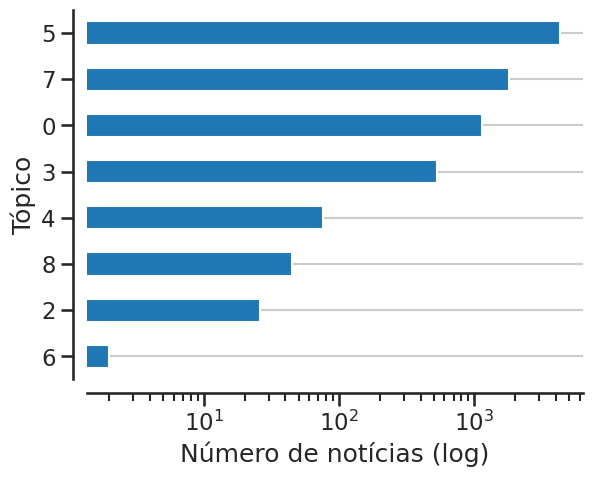

In [31]:
#Disctribuição de Tópicos LDA
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

### Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


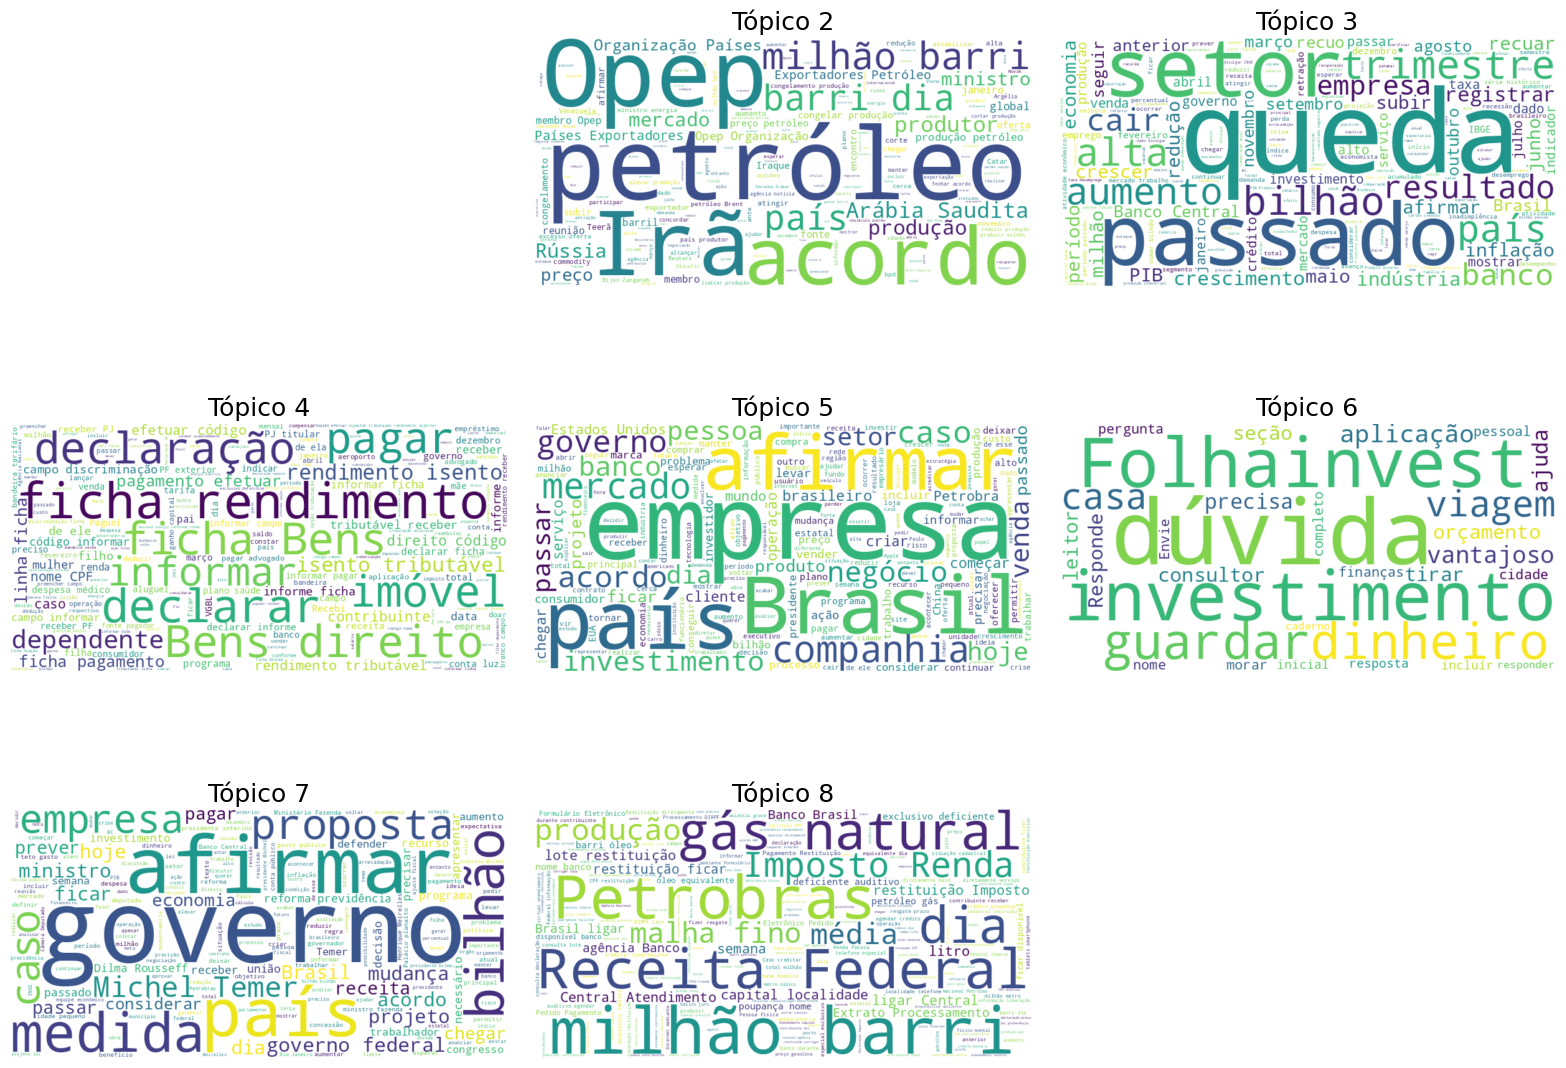

In [32]:
def plot_wordcloud(text, ax):
    """
    Plot the wordcloud for the text.

    Arguments:
        - text: string to be analyzed.
        - ax: plt subaxis.

    Returns:
        - ax.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

### Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


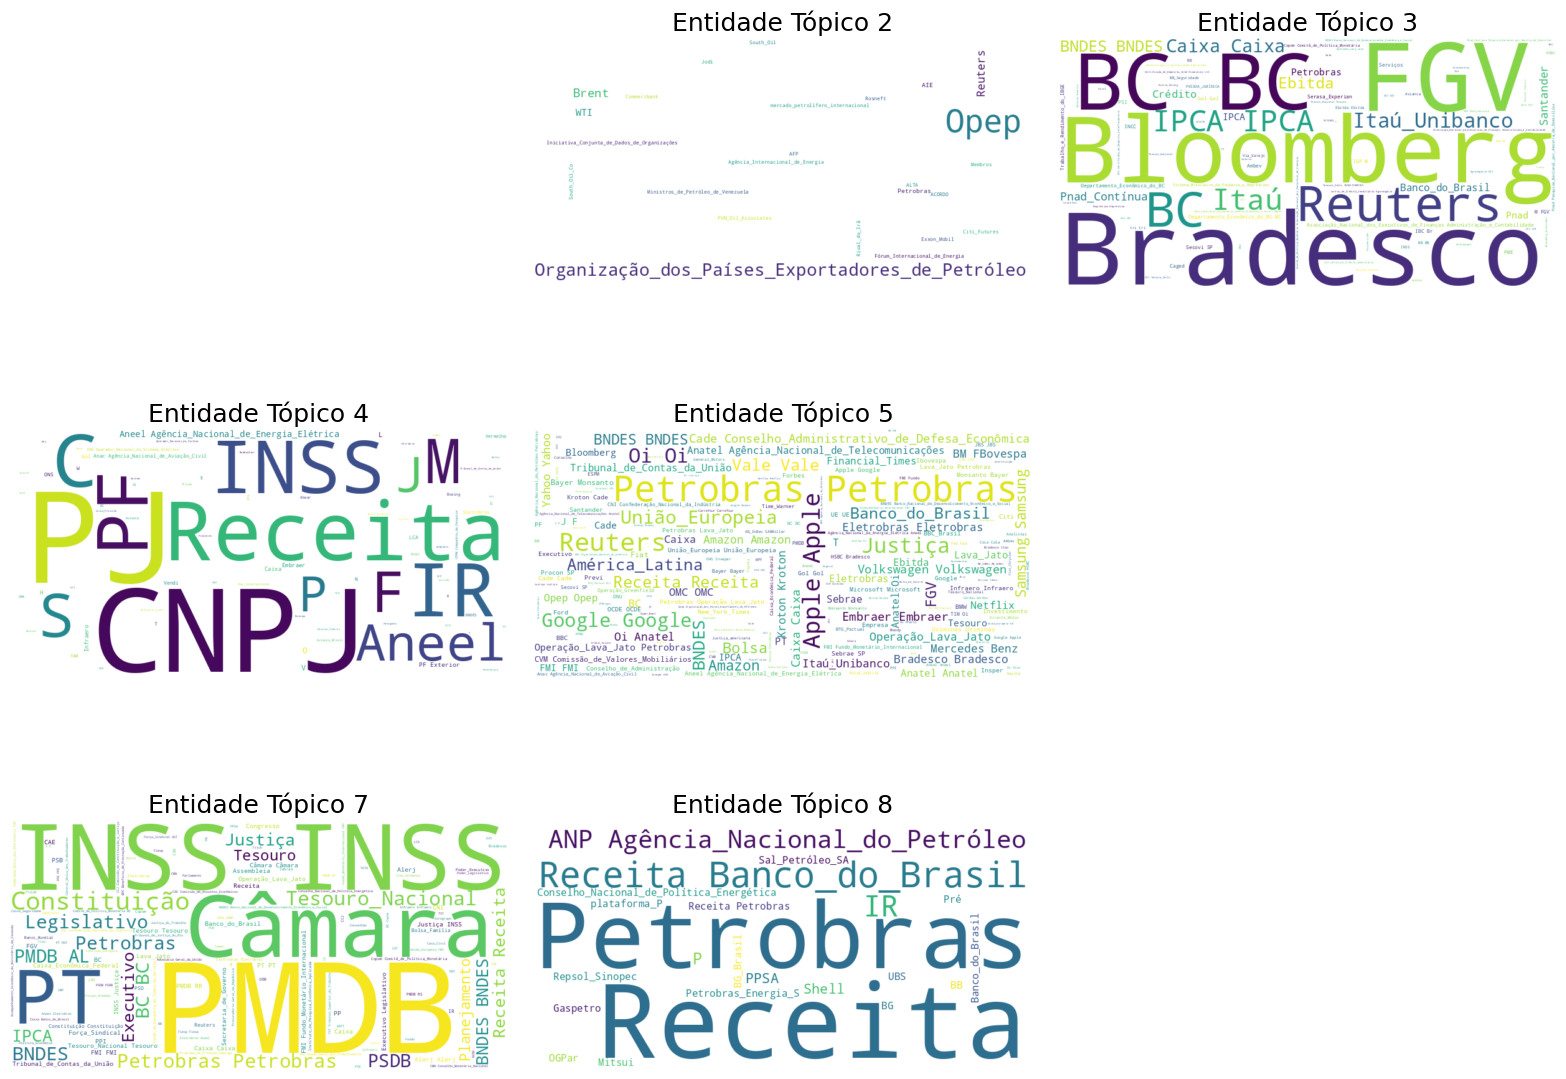

In [33]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Entidade Tópico {idx + 1}")
fig.tight_layout()

##  Bag-of-Words (Doc2Vec)

In [34]:
class VectorizerDoc2Vec:
    def __init__(self, doc_tokens: List, max_features: int = 5000, min_df: int = 10, vector_size: int = 100, window: int = 5, min_count: int = 5):
        self.doc_tokens = doc_tokens
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None
        self.tfidf = None

    def train_doc2vec(self):
        tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(self.doc_tokens)]
        self.model = Doc2Vec(vector_size=self.vector_size, window=self.window, min_count=self.min_count, workers=4)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=30)

    def vectorize(self):
        if self.model is None:
            self.train_doc2vec()

    def tokens2vec(self, tokens):
        vec = self.model.infer_vector(tokens)
        return vec

    def __call__(self):
        self.vectorize()
        vectors = [self.tokens2vec(tokens) for tokens in self.doc_tokens]
        return vectors

doc_tokens = news_2016.spacy_lemma.values.tolist()
Vectorizer_doc2vec = VectorizerDoc2Vec(doc_tokens)

doc2vec_vectors = Vectorizer_doc2vec()

def tokens2vec(tokens):
    vec = Vectorizer_doc2vec.tokens2vec(tokens)
    return vec

news_2016['doc2vec'] = news_2016.spacy_lemma.progress_apply(tokens2vec)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

In [ ]:
news_2016.head()

### Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

#### Grid Search Tuning

In [ ]:
'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Dividir os dados em treinamento e teste
X_train, X_test = train_test_split(doc2vec_vectors, test_size=0.2, random_state=SEED)

MAX_ITER = 100

param_grid = {
    'n_clusters': range(1, 50)  # Ajuste o intervalo com base nos seus dados e necessidades
}

kmeans = KMeans(max_iter=MAX_ITER, random_state=SEED)

grid_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)  # Ajuste cv para o número desejado de dobras

grid_kmeans.fit(X_train)

best_kmeans = grid_kmeans.best_estimator_

best_n_clusters = grid_kmeans.best_params_['n_clusters']
print('Melhor Número de Tópicos:', best_n_clusters)


# Prever os rótulos dos clusters para os dados de teste
test_labels = best_kmeans.predict(X_test)

# Calcular a pontuação de silhueta para avaliação
silhouette_avg = silhouette_score(X_test, test_labels)
calinski_harabasz_index = calinski_harabasz_score(X_test, test_labels)
davies_bouldin_index = davies_bouldin_score(X_test, test_labels)

print(f"Silhouette Score para {best_n_clusters} clusters: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Davies-Bouldin Index: {davies_bouldin_index}")
'''

### Doc2Vec / K-Means

In [43]:
from sklearn.cluster import KMeans

N_TOKENS = 9
MAX_ITER = 100

# Criar e ajustar o modelo K-Médias
n_clusters = 9
kmeans = KMeans(n_clusters=N_TOKENS, max_iter=MAX_ITER, random_state=SEED)
kmeans.fit(doc2vec_vectors)

# Adicionar os rótulos dos clusters ao DataFrame
news_2016['kmeans'] = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Número de documentos vs tópicos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


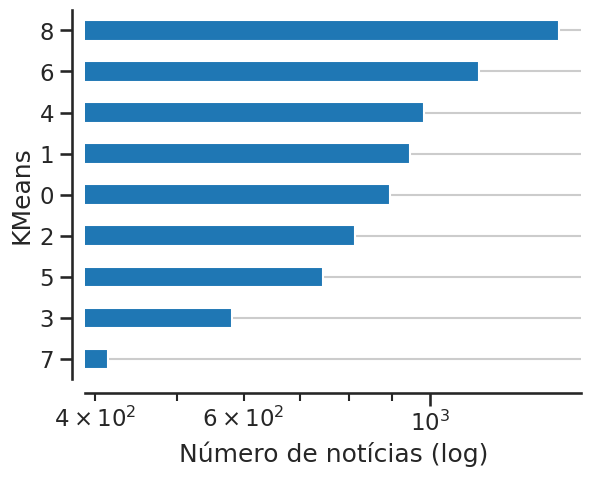

In [52]:
#Disctribuição de Tópicos KMeans
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['kmeans'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("KMeans")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

### Crie uma nuvem de palavra para cada tópico.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


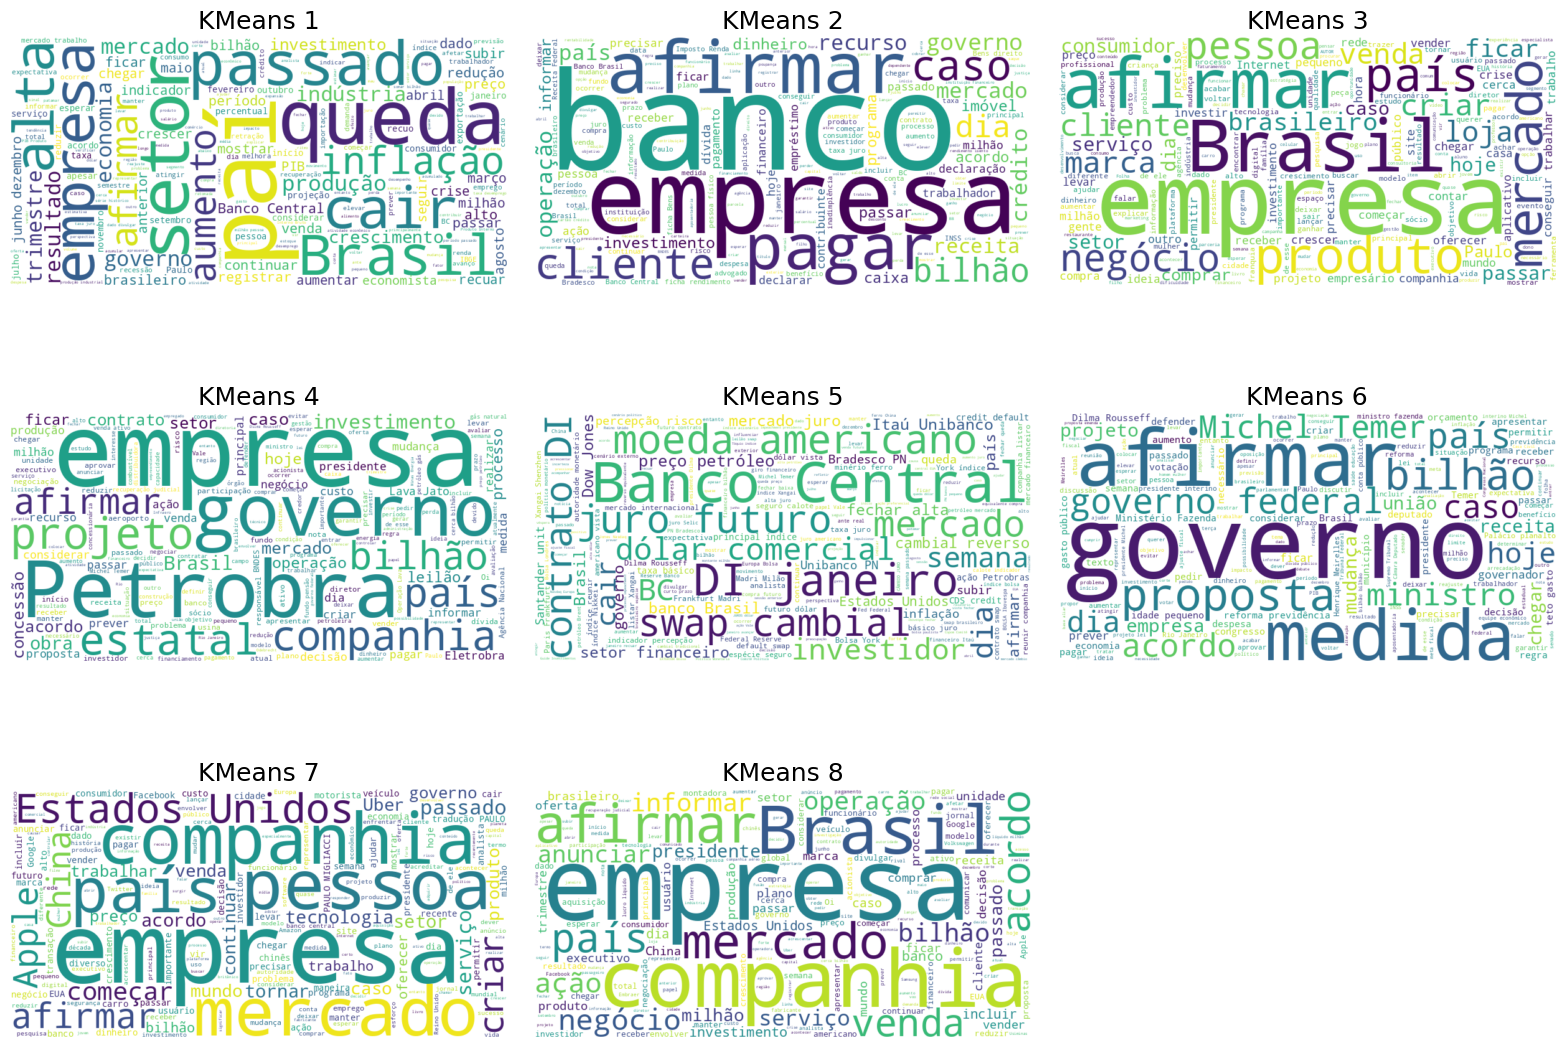

In [41]:
def plot_wordcloud(text, ax):
    """
    Plot the wordcloud for the text.

    Arguments:
        - text: string to be analyzed.
        - ax: plt subaxis.

    Returns:
        - ax.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['kmeans'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"KMeans {idx + 1}")
fig.tight_layout()

### Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


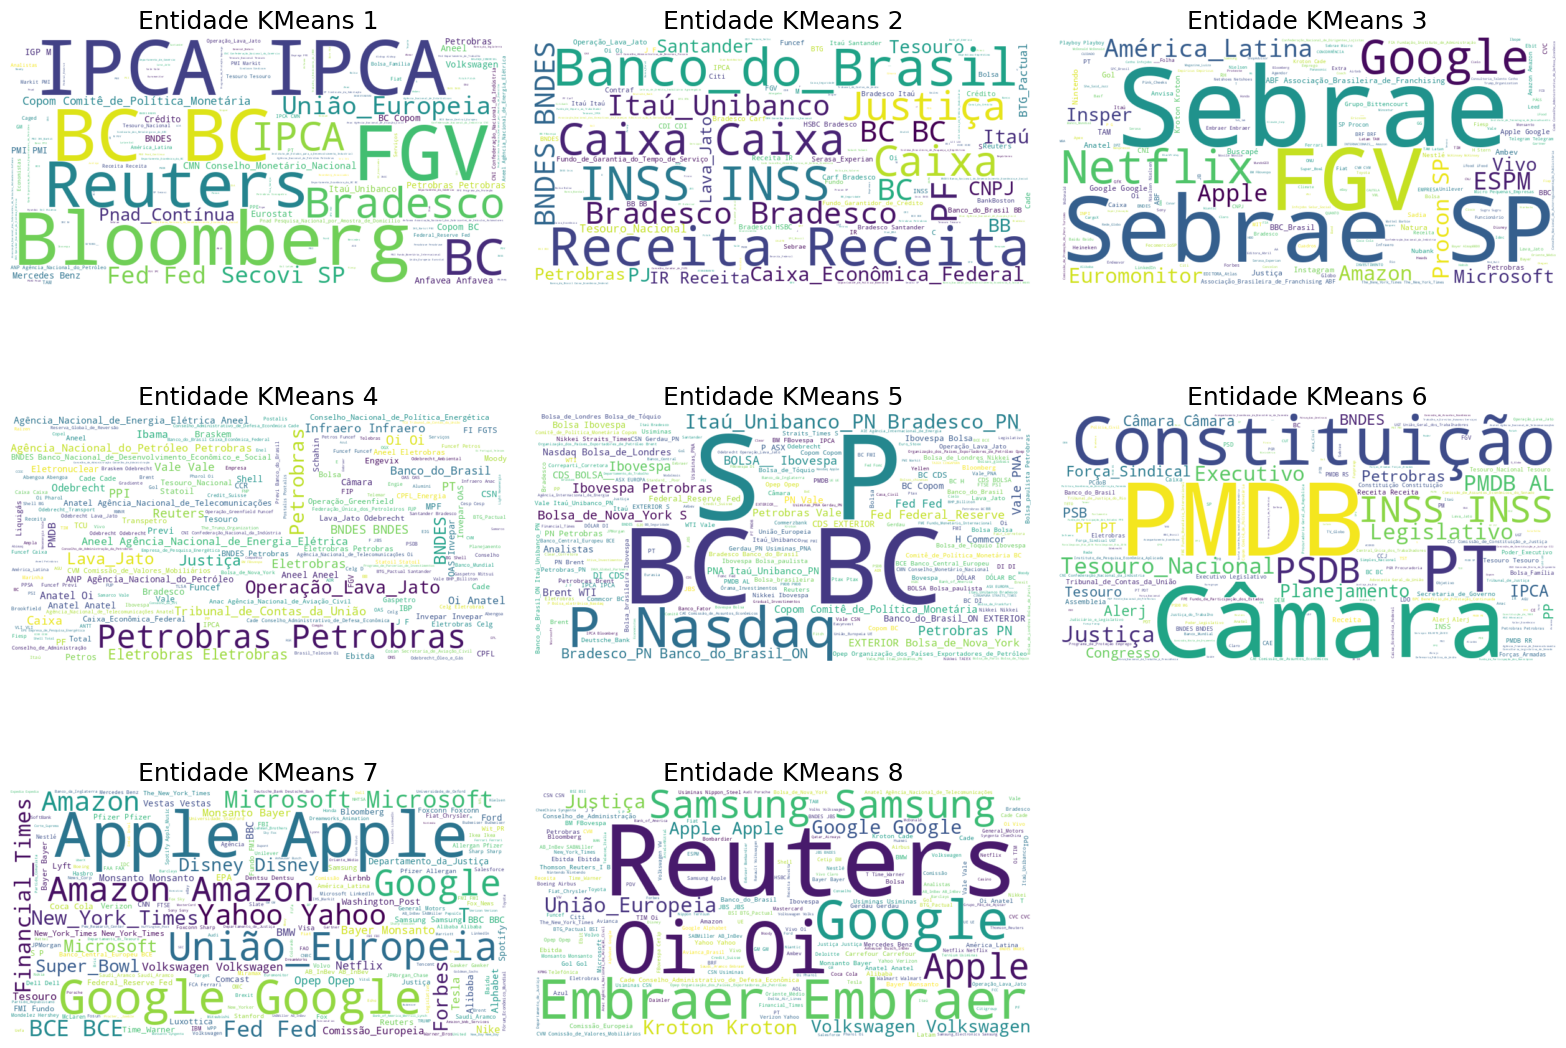

In [42]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['kmeans'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Entidade KMeans {idx + 1}")
fig.tight_layout()